# Using R Functions in Python

This notebook provides all of the code present in the Medium article **Guide to R and Python in a Single Jupyter Notebook**. The focus on the notebook is on the use of R functions, libraries, vectors, dataframes, and formula within a Python notebook and how to interface between the Python and R environment. Following this, examples of using these features are given with the examples of smoothing splines, natural and basis splines, as well as generalized additive models (GAMs).

**Author:** <a href="https://github.com/Srtgn">Saeed Rastegarian</a> based on <a href="https://github.com/mrdragonbear">Matthew Stewart</a>'s notebook<br>

<span style="color:red">
If you have configured your python environment based on the instructions in <a href="https://github.com/bmcs-group/bmcs_utils/blob/master/docs/README.md">BMCS development process</a>, please add the following packages to use the "R" parts of this notebook:</span>

conda install -c r rpy2

conda install -c conda-forge tzlocal

conda install -c conda-forge r-gam


In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

## Learning Goals

The main goal of this notebook is to get familiar with calling R functions within Python. Along the way, we'll learn about the "formula" interface to statsmodels, which gives an intuitive way of specifying regression models, and we'll review the different approaches to fitting curves.

Key Skills:
- Importing (base) R functions
- Importing R library functions
- Populating vectors R understands
- Populating dataframes R understands
- Populating formulas R understands
- Running models in R
- Getting results back to Python
- Getting model predictions in R
- Plotting in R
- Reading R's documentation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 

## Linear/Polynomial Regression (Python, Review)
Hopefully, you are at least somewhat familiar with using the statsmodels package in Python.

Reading data and (some) exploring in Pandas:

In [3]:
diab = pd.read_csv("data/diabetes.csv")
print("""
# Variables are:
#   subject:   subject ID number
#   age:       age diagnosed with diabetes
#   acidity:   a measure of acidity called base deficit
#   y:         natural log of serum C-peptide concentration
#
# Original source is Sockett et al. (1987)
# mentioned in Hastie and Tibshirani's book 
# "Generalized Additive Models".
""")

display(diab.head())
display(diab.dtypes)
display(diab.describe())


# Variables are:
#   subject:   subject ID number
#   age:       age diagnosed with diabetes
#   acidity:   a measure of acidity called base deficit
#   y:         natural log of serum C-peptide concentration
#
# Original source is Sockett et al. (1987)
# mentioned in Hastie and Tibshirani's book 
# "Generalized Additive Models".



,subject,age,acidity,y
0,1,5.2,-8.1,4.8
1,2,8.8,-16.1,4.1
2,3,10.5,-0.9,5.2
3,4,10.6,-7.8,5.5
4,5,10.4,-29.0,5.0


subject      int64
age        float64
acidity    float64
y          float64
dtype: object

,subject,age,acidity,y
count,43.000000,43.000000,43.000000,43.000000
mean,22.000000,9.032558,-8.148837,4.746512
std,12.556539,4.022539,7.123080,0.720565
min,1.000000,0.900000,-29.000000,3.000000
25%,11.500000,5.500000,-12.700000,4.450000
50%,22.000000,10.400000,-7.800000,4.900000
75%,32.500000,11.850000,-2.000000,5.100000
max,43.000000,15.600000,-0.200000,6.600000


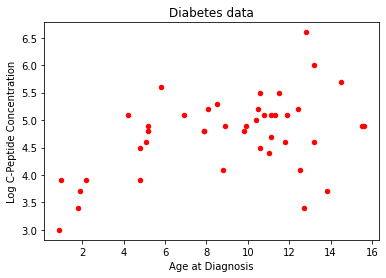

In [4]:
ax0 = diab.plot.scatter(x='age',y='y',c='Red',title="Diabetes data") #plotting direclty from pandas!
ax0.set_xlabel("Age at Diagnosis")
ax0.set_ylabel("Log C-Peptide Concentration");

Linear regression with statsmodels. 

- Previously, we worked from a vector of target values and a design matrix we built ourself (e.g. from PolynomialFeatures). 
- Now, Statsmodels' *formula interface* can help build the target value and design matrix for you.

In [5]:
#Using statsmodels
import statsmodels.formula.api as sm


model1 = sm.ols('y ~ age',data=diab)
fit1_lm = model1.fit()

Build a data frame to predict values on (sometimes this is just the test or validation set)
 - Very useful for making pretty plots of the model predcitions -- predict for TONS of values, not just whatever's in the training set

In [6]:
x_pred = np.linspace(0,16,100)

predict_df = pd.DataFrame(data={"age":x_pred})
predict_df.head()

,age
0,0.000000
1,0.161616
2,0.323232
3,0.484848
4,0.646465


Use `get_prediction(<data>).summary_frame()` to get the model's prediction (and error bars!)

In [7]:
prediction_output = fit1_lm.get_prediction(predict_df).summary_frame()
prediction_output.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,3.996031,0.244590,3.502071,4.489991,2.600828,5.391235
1,4.009459,0.240929,3.522892,4.496026,2.616856,5.402063
2,4.022887,0.237280,3.543691,4.502084,2.632842,5.412932
3,4.036315,0.233642,3.564466,4.508165,2.648786,5.423845
4,4.049743,0.230016,3.585216,4.514270,2.664687,5.434800


Plot the model and error bars

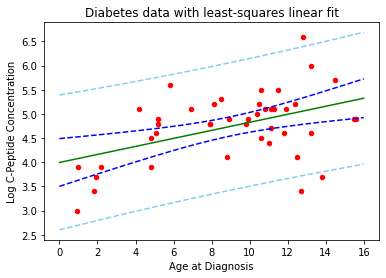

In [8]:
ax1 = diab.plot.scatter(x='age',y='y',c='Red',title="Diabetes data with least-squares linear fit")
ax1.set_xlabel("Age at Diagnosis")
ax1.set_ylabel("Log C-Peptide Concentration")


ax1.plot(predict_df.age, prediction_output['mean'],color="green")
ax1.plot(predict_df.age, prediction_output['mean_ci_lower'], color="blue",linestyle="dashed")
ax1.plot(predict_df.age, prediction_output['mean_ci_upper'], color="blue",linestyle="dashed");

ax1.plot(predict_df.age, prediction_output['obs_ci_lower'], color="skyblue",linestyle="dashed")
ax1.plot(predict_df.age, prediction_output['obs_ci_upper'], color="skyblue",linestyle="dashed");

<div class="exercise"><b>Exercise 1</b></div>

1. Fit a 3rd degree polynomial model and plot the model+error bars
 - Route1: Build a design df with a column for each of `age`, `age**2`, `age**3`
 - Route2: Just edit the formula

In [9]:
fit2_lm = sm.ols(formula="y ~ age + np.power(age, 2) + np.power(age, 3)",data=diab).fit()

poly_predictions = fit2_lm.get_prediction(predict_df).summary_frame()
poly_predictions.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,2.740481,0.508197,1.712556,3.768406,1.156238,4.324724
1,2.846265,0.472858,1.889819,3.802710,1.307439,4.385090
2,2.948751,0.439558,2.059661,3.837841,1.450860,4.446641
3,3.047990,0.408303,2.222119,3.873860,1.586737,4.509242
4,3.144031,0.379104,2.377221,3.910841,1.715328,4.572735


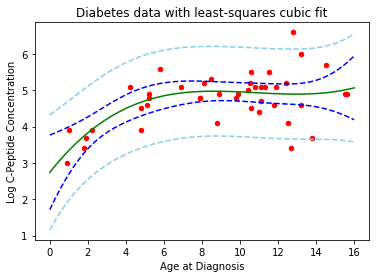

In [10]:
ax2 = diab.plot.scatter(x='age',y='y',c='Red',title="Diabetes data with least-squares cubic fit")
ax2.set_xlabel("Age at Diagnosis")
ax2.set_ylabel("Log C-Peptide Concentration")

ax2.plot(predict_df.age, poly_predictions['mean'],color="green")
ax2.plot(predict_df.age, poly_predictions['mean_ci_lower'], color="blue",linestyle="dashed")
ax2.plot(predict_df.age, poly_predictions['mean_ci_upper'], color="blue",linestyle="dashed");

ax2.plot(predict_df.age, poly_predictions['obs_ci_lower'], color="skyblue",linestyle="dashed")
ax2.plot(predict_df.age, poly_predictions['obs_ci_upper'], color="skyblue",linestyle="dashed");

## Linear/Polynomial Regression, but make it R

This is the meat of the lab. After this section we'll know everything we need to in order to work with R models. The rest of the lab is just applying these concepts to run particular models. This section therefore is your 'cheat sheet' for working in R.

What we need to know:
- Importing (base) R functions
- Importing R Library functions
- Populating vectors R understands
- Populating DataFrames R understands
- Populating Formulas R understands
- Running models in R
- Getting results back to Python
- Getting model predictions in R
- Plotting in R
- Reading R's documentation

**Importing R functions**

In [11]:
# if you're on JupyterHub you may need to specify the path to R

# import os
# os.environ['R_HOME'] = "/home/matt.stewart/anaconda3/bin/R"

import rpy2.robjects as robjects

In [12]:
r_lm = robjects.r["lm"]
r_predict = robjects.r["predict"]
#r_plot = robjects.r["plot"] # more on plotting later

#lm() and predict() are two of the most common functions we'll use

**Importing R libraries**

In [13]:
from rpy2.robjects.packages import importr
#r_cluster = importr('cluster')
#r_cluster.pam;

**Populating vectors R understands**

In [14]:
r_y = robjects.FloatVector(diab['y'])
r_age = robjects.FloatVector(diab['age'])
# What happens if we pass the wrong type?
# How does r_age display?
# How does r_age print?

**Populating Data Frames R understands**

In [15]:
diab_r = robjects.DataFrame({"y":r_y, "age":r_age})
# How does diab_r display?
# How does diab_r print?

**Populating formulas R understands**

In [16]:
simple_formula = robjects.Formula("y~age")
simple_formula.environment["y"] = r_y #populate the formula's .environment, so it knows what 'y' and 'age' refer to
simple_formula.environment["age"] = r_age

**Running Models in R**

In [17]:
diab_lm = r_lm(formula=simple_formula) # the formula object is storing all the needed variables

In [18]:
simple_formula = robjects.Formula("y~age") # reset the formula
diab_lm = r_lm(formula=simple_formula, data=diab_r) #can also use a 'dumb' formula and pass a dataframe

**Getting results back to Python**

In [19]:
diab_lm #the result is already 'in' python, but it's a special object

R object with classes: ('lm',) mapped to:
<ListVector - Python:0x00000231252AF988 / R:0x00000231244551C0>
[FloatVector, FloatVector, FloatVector, IntVector, ..., ListVector, Vector, Formula, DataFrame]
  coefficients: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x00000231258A88C8 / R:0x0000023125B05B98>
[3.996031, 0.083086]
  residuals: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x00000231142FB708 / R:0x0000023125B35248>
[0.371921, -0.627189, 0.331564, 0.623256, ..., -0.934608, -0.492768, 0.164502, 0.206638]
  effects: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x00000231258C4848 / R:0x0000023125B353D8>
[-31.124958, -2.165975, 0.333051, 0.627310, ..., -0.881769, -0.421956, 0.124907, 0.215828]
  rank: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x00000231258C4308 / R:0x0000023125B32A78>
[2]
...
R object with classes: ('lm',) mapped to:
<ListVector - Python:0x00000231252AF988 / R:0x00000231244551C0>
[FloatVector, FloatVector, FloatVector, IntVector, ..., ListVector, Vector, Formula, DataFrame]
  qr: <class 'rpy2.robjects.vectors.Vector'>
  R object with classes: ('lm',) mapped to:
<Vector - Python:0x00000231258CC908 / R:0x0000023125B03E28>
[SignatureTrans..., Formula, DataFrame]
  df.residual: <class 'rpy2.robjects.Formula'>
  R object with classes: ('terms', 'formula') mapped to:
<Formula - Python:0x00000231258AE6C8 / R:0x0000023125B226B0>
R object with classes: ('lm',) mapped to:
<ListVector - Python:0x00000231252AF988 / R:0x00000231244551C0>
[FloatVector, FloatVector, FloatVector, IntVector, ..., ListVector, Vector, Formula, DataFrame]

In [20]:
print(diab_lm.names) # view all names

 [1] "coefficients"  "residuals"     "effects"       "rank"         

 [5] "fitted.values" "assign"        "qr"            "df.residual"  

 [9] "xlevels"       "call"          "terms"         "model"        



In [21]:
diab_lm[0] #grab the first element

3.996031,0.083086


In [22]:
diab_lm.rx2("coefficients") #use rx2 to get elements by name!

3.996031,0.083086


In [23]:
np.array(diab_lm.rx2("coefficients")) #r vectors can be converted to numpy (but rarely needed)

array([3.99603115, 0.08308615])

**Getting Predictions**

In [24]:
# make a df to predict on (might just be the validation or test dataframe)
predict_df = robjects.DataFrame({"age": robjects.FloatVector(np.linspace(0,16,100))})

# call R's predict() function, passing the model and the data 
predictions = r_predict(diab_lm, predict_df)

In [25]:
x_vals = predict_df.rx2("age")

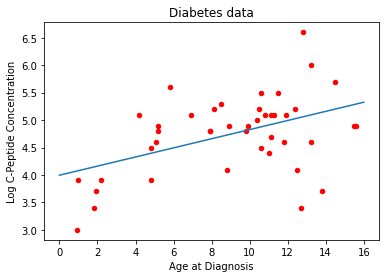

In [26]:
ax = diab.plot.scatter(x='age',y='y',c='Red',title="Diabetes data")
ax.set_xlabel("Age at Diagnosis")
ax.set_ylabel("Log C-Peptide Concentration");

ax.plot(x_vals,predictions); #plt still works with r vectors as input!

**Plotting in R**

In [27]:
%load_ext rpy2.ipython

C:\Users\srate\miniconda3\envs\py37\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


- The above turns on the %R "magic"
- R's plot() command responds differently based on what you hand to it; Different models get different plots!
 - For any specific model search for plot.modelname. E.g. for a GAM model, search plot.gam for any details of plotting a GAM model
- The %R "magic" runs R code in 'notebook' mode, so figures display nicely
  - Ahead of the `plot(<model>)` code we pass in the variables R needs to know about (`-i` is for "input")

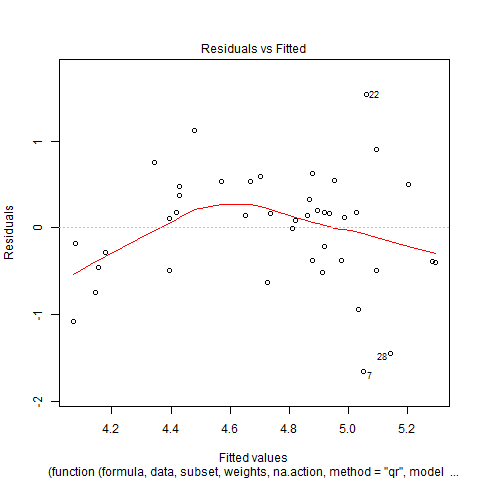

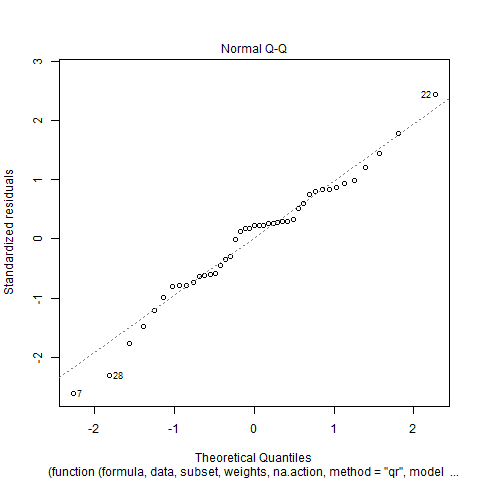

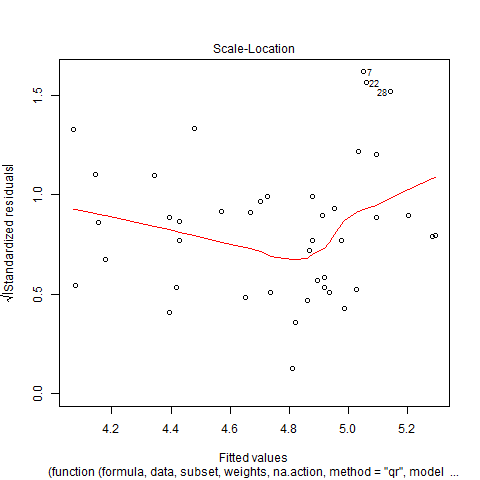

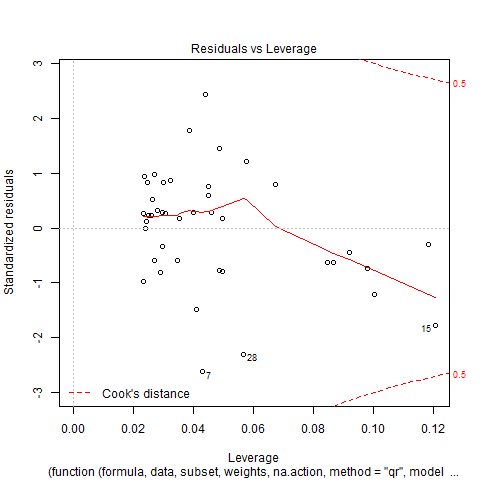

In [28]:
%R -i diab_lm plot(diab_lm);

The documentation for the `lm()` funciton is [here](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/lm.html), and a prettier version (same content) is [here](https://www.rdocumentation.org/packages/stats/versions/3.5.2/topics/lm). When googling, perfer rdocumentation.org when possible.
Sections:
 - **Usage**: gives the function signature, including all optional arguments
 - **Arguments**: What each function input controls
 - **Details**: additional info on what the funciton *does* and how arguments interact. **Often the right place to start reading**
 - **Value**: the structure of the object returned by the function
 - **Refferences**: The relevant academic papers
 - **See Also**: other functions of interest

<div class="exercise"><b>Exercise 2</b></div>

1. Add confidence intervals calculated in R to the linear regression plot above. Use the `interval=` argument to `r_predict()` (documentation [here](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/predict.lm.html)). You will have to work with a matrix returned by R.
2. Fit a 5th degree polynomial to the diabetes data in R. Search the web for an easier method than writing out a formula with all 5 polynomial terms.

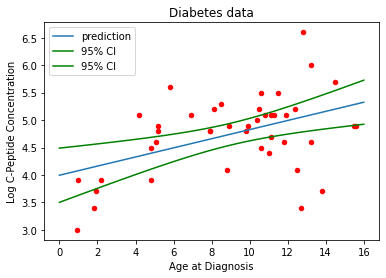

In [29]:
CI_matrix = np.array(r_predict(diab_lm, predict_df, interval="confidence"))

ax = diab.plot.scatter(x='age',y='y',c='Red',title="Diabetes data")
ax.set_xlabel("Age at Diagnosis")
ax.set_ylabel("Log C-Peptide Concentration");

ax.plot(x_vals,CI_matrix[:,0], label="prediction")
ax.plot(x_vals,CI_matrix[:,1], label="95% CI", c='g')
ax.plot(x_vals,CI_matrix[:,2], label="95% CI", c='g')
plt.legend();

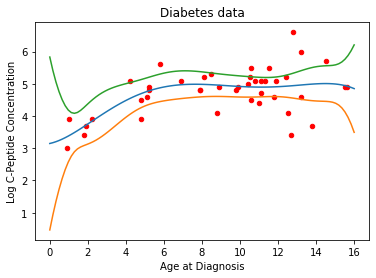

In [30]:
ploy5_formula = robjects.Formula("y~poly(age,5)") # reset the formula
diab5_lm = r_lm(formula=ploy5_formula, data=diab_r) #can also use a 'dumb' formula and pass a dataframe

predictions = r_predict(diab5_lm, predict_df, interval="confidence")

ax = diab.plot.scatter(x='age',y='y',c='Red',title="Diabetes data")
ax.set_xlabel("Age at Diagnosis")
ax.set_ylabel("Log C-Peptide Concentration");

ax.plot(x_vals,predictions);

## Lowess Smoothing
Lowess Smoothing is implemented in both Python and R. We'll use it as another example as we transition languages. 

**In Python**

In [31]:
from statsmodels.nonparametric.smoothers_lowess import lowess as lowess

ss1 = lowess(diab['y'],diab['age'],frac=0.15)
ss2 = lowess(diab['y'],diab['age'],frac=0.25)
ss3 = lowess(diab['y'],diab['age'],frac=0.7)
ss4 = lowess(diab['y'],diab['age'],frac=1)

In [32]:
ss1[:10,:] # we get back simple a smoothed y value for each x value in the data

array([[0.9       , 3.22071129],
       [1.        , 3.26459047],
       [1.8       , 3.62356396],
       [1.9       , 3.66837986],
       [2.2       , 3.80550938],
       [4.2       , 5.0920864 ],
       [4.8       , 4.19014581],
       [4.8       , 4.19014581],
       [5.1       , 4.66468111],
       [5.2       , 4.82679775]])

Notice the clean code to plot different models. We'll see even cleaner code in a minute

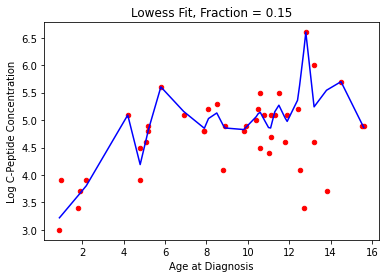

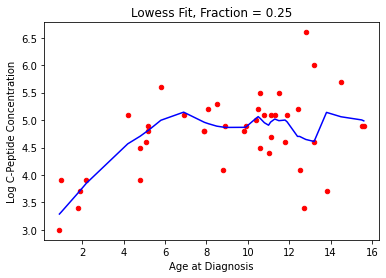

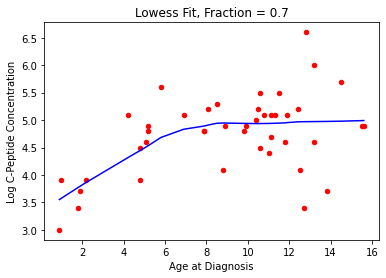

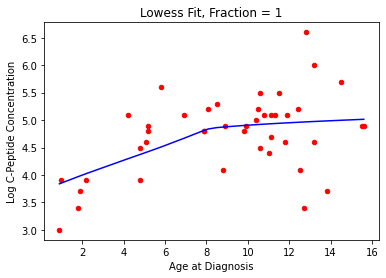

In [33]:
for cur_model, cur_frac in zip([ss1,ss2,ss3,ss4],[0.15,0.25,0.7,1]):

    ax = diab.plot.scatter(x='age',y='y',c='Red',title="Lowess Fit, Fraction = {}".format(cur_frac))
    ax.set_xlabel("Age at Diagnosis")
    ax.set_ylabel("Log C-Peptide Concentration")
    ax.plot(cur_model[:,0],cur_model[:,1],color="blue")
    
    plt.show()

**In R**  

We need to:
 - Import the loess function
 - Send data over to R
 - Call the function and get results

In [34]:
r_loess = robjects.r['loess.smooth'] #extract R function
r_y = robjects.FloatVector(diab['y'])
r_age = robjects.FloatVector(diab['age'])

ss1_r = r_loess(r_age,r_y, span=0.15, degree=1)

In [35]:
ss1_r #again, a smoothed y value for each x value in the data

R object with classes: ('list',) mapped to:
<ListVector - Python:0x0000023128728348 / R:0x0000023125F05E48>
[FloatVector, FloatVector]
  x: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000023128721388 / R:0x00000231259D23D8>
[0.900000, 1.200000, 1.500000, 1.800000, ..., 14.700000, 15.000000, 15.300000, 15.600000]
  y: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000023128728608 / R:0x00000231230D2950>
[3.311816, 3.420293, 3.530318, 3.640274, ..., 5.545358, 5.316981, 5.090513, 4.864094]

**Varying span**  
Next, some extremely clean code to fit and plot models with various parameter settings. (Though the `zip()` method seen earlier is great when e.g. the label and the parameter differ)

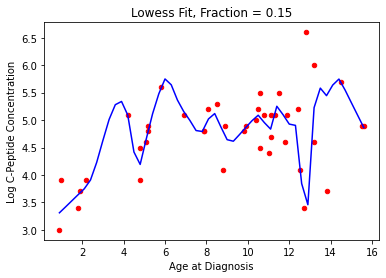

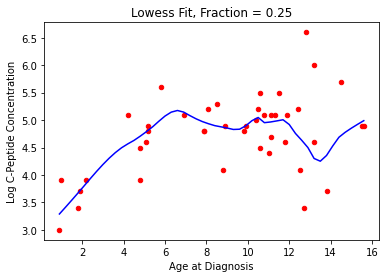

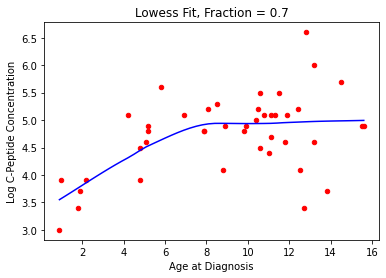

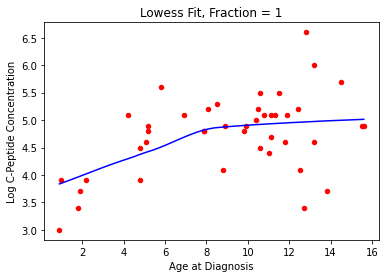

In [36]:
for cur_frac in [0.15,0.25,0.7,1]:
    
    cur_smooth = r_loess(r_age,r_y, span=cur_frac)

    ax = diab.plot.scatter(x='age',y='y',c='Red',title="Lowess Fit, Fraction = {}".format(cur_frac))
    ax.set_xlabel("Age at Diagnosis")
    ax.set_ylabel("Log C-Peptide Concentration")
    ax.plot(cur_smooth[0], cur_smooth[1], color="blue")
    
    plt.show()

## Smoothing Splines
From this point forward, we're working with R functions; these models aren't (well) supported in Python.

For clarity: this is the fancy spline model that minimizes $MSE - \lambda\cdot\text{wiggle penalty}$ $=$ $\sum_{i=1}^N \left(y_i - f(x_i)\right)^2 - \lambda \int \left(f''(x)\right)^2$, across all possible functions $f$. The winner will always be a continuous, cubic polynomial with a knot at each data point

In [37]:
r_smooth_spline = robjects.r['smooth.spline'] #extract R function

# run smoothing function
spline1 = r_smooth_spline(r_age, r_y, spar=0)

<div class="exercise"><b>Exercise 3</b></div>

1. We actually set the spar parameter, a scale-free value that translates to a $\lambda$ through a complex expression. Inspect the 'spline1' result and extract the implied value of $\lambda$
2. Working from the fitting/plotting loop examples above, produce a plot like the one below for spar = [0,.5,.9,2], including axes labels and title.

In [38]:
lambda1 = spline1.rx2("lambda")

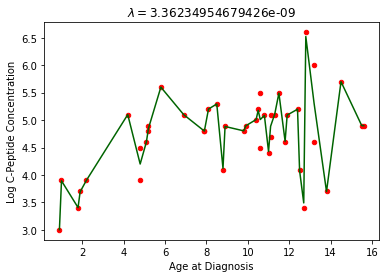

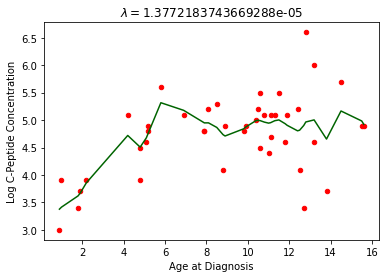

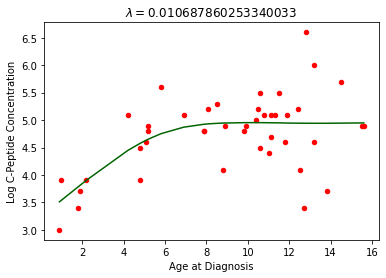

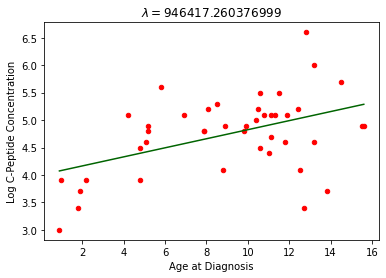

In [39]:
for cur_spar in [0,0.5,0.9,2]:
    
    cur_model = r_smooth_spline(r_age, r_y, spar= cur_spar)
    cur_lambda = cur_model.rx2("lambda")[0]
    
    ax = diab.plot.scatter(x='age',y='y',c='Red',title="$\lambda=$"+str(cur_lambda)) #can use TeX style in labels
    ax.set_xlabel("Age at Diagnosis")
    ax.set_ylabel("Log C-Peptide Concentration")
    ax.plot(cur_model.rx2("x"),cur_model.rx2("y"),color="darkgreen")
    
    plt.show()

**CV**  
R's `smooth_spline` funciton has built-in CV to find a good lambda. See package [docs](https://www.rdocumentation.org/packages/stats/versions/3.5.2/topics/smooth.spline).

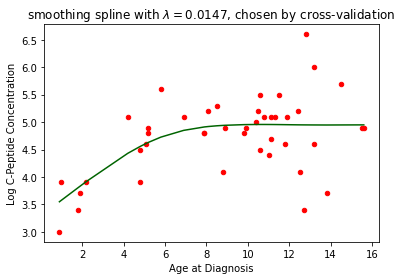

In [40]:
spline_cv = r_smooth_spline(r_age, r_y, cv=True) 

lambda_cv = spline_cv.rx2("lambda")[0]

ax19 = diab.plot.scatter(x='age',y='y',c='Red',title="smoothing spline with $\lambda=$"+str(np.round(lambda_cv,4))+", chosen by cross-validation")
ax19.set_xlabel("Age at Diagnosis")
ax19.set_ylabel("Log C-Peptide Concentration")
ax19.plot(spline_cv.rx2("x"),spline_cv.rx2("y"),color="darkgreen");

## Natural & Basis Splines
Here, we take a step backward on model complexity, but a step forward in coding complexity. We'll be working with R's formula interface again, so we will need to populate Formulas and DataFrames.

In [41]:
#We will now work with a new dataset, called GAGurine.
#The dataset description (from the R package MASS) is below:
#Data were collected on the concentration of a chemical GAG 
# in the urine of 314 children aged from zero to seventeen years. 
# The aim of the study was to produce a chart to help a paediatrican
# to assess if a child's GAG concentration is ‘normal’.

#The variables are:
# Age: age of child in years.
# GAG: concentration of GAG (the units have been lost).

,Age,GAG
0,0.00,23.0
1,0.00,23.8
2,0.00,16.9
3,0.00,18.6
4,0.01,17.9


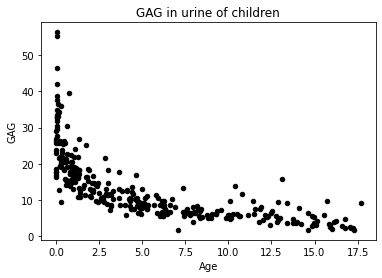

In [42]:
GAGurine = pd.read_csv("data/GAGurine.csv")
display(GAGurine.head())

ax31 = GAGurine.plot.scatter(x='Age',y='GAG',c='black',title="GAG in urine of children")
ax31.set_xlabel("Age");
ax31.set_ylabel("GAG");

Standard stuff: import function, convert variables to R format, call function

In [43]:
from rpy2.robjects.packages import importr
r_splines = importr('splines')

# populate R variables
r_gag = robjects.FloatVector(GAGurine['GAG'].values)
r_age = robjects.FloatVector(GAGurine['Age'].values)
r_quarts = robjects.FloatVector(np.quantile(r_age,[.25,.5,.75])) #woah, numpy functions run on R objects!

What happens when we call the ns or bs functions from r_splines?

In [44]:
ns_design = r_splines.ns(r_age, knots=r_quarts)
bs_design = r_splines.bs(r_age, knots=r_quarts)

In [45]:
print(ns_design)

                  1            2           3            4

  [1,] 0.000000e+00  0.000000000 0.000000000  0.000000000

  [2,] 0.000000e+00  0.000000000 0.000000000  0.000000000

  [3,] 0.000000e+00  0.000000000 0.000000000  0.000000000

  [4,] 0.000000e+00  0.000000000 0.000000000  0.000000000

  [5,] 3.064149e-08 -0.001934587 0.004727391 -0.002792803

  [6,] 3.064149e-08 -0.001934587 0.004727391 -0.002792803

  [7,] 3.064149e-08 -0.001934587 0.004727391 -0.002792803

  [8,] 3.064149e-08 -0.001934587 0.004727391 -0.002792803

  [9,] 3.064149e-08 -0.001934587 0.004727391 -0.002792803

 [10,] 3.064149e-08 -0.001934587 0.004727391 -0.002792803

 [11,] 3.064149e-08 -0.001934587 0.004727391 -0.002792803

 [12,] 2.451319e-07 -0.003869017 0.009454395 -0.005585378

 [13,] 2.451319e-07 -0.003869017 0.009454395 -0.005585378

 [14,] 8.273203e-07 -0.005803130 0.014180627 -0.008377497

 [15,] 8.273203e-07 -0.005803130 0.014180627 -0.008377497

 [16,] 8.273203e-07 -0.005803130 0.014180627 -0.00837749

`ns` and `bs` return design matrices, not model objects! That's because they're meant to work with `lm`'s formula interface. To get a model object we populate a formula including `ns(<var>,<knots>)` and fit to data

In [46]:
r_lm = robjects.r['lm']
r_predict = robjects.r['predict']

# populate the formula
ns_formula = robjects.Formula("Gag ~ ns(Age, knots=r_quarts)")
ns_formula.environment['Gag'] = r_gag
ns_formula.environment['Age'] = r_age
ns_formula.environment['r_quarts'] = r_quarts
         
# fit the model
ns_model = r_lm(ns_formula)

Predict like usual: build a dataframe to predict on and call `predict()`

In [47]:
# predict
predict_frame = robjects.DataFrame({"Age": robjects.FloatVector(np.linspace(0,20,100))})

ns_out = r_predict(ns_model, predict_frame)

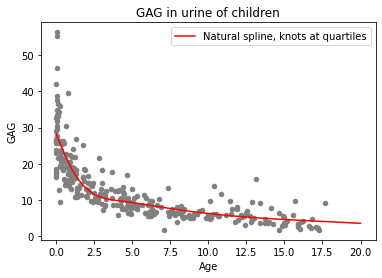

In [48]:
ax32 = GAGurine.plot.scatter(x='Age',y='GAG',c='grey',title="GAG in urine of children")
ax32.set_xlabel("Age")
ax32.set_ylabel("GAG")
ax32.plot(predict_frame.rx2("Age"),ns_out, color='red')
ax32.legend(["Natural spline, knots at quartiles"]);

<div class="exercise"><b>Exercise 4</b></div>

1. Fit a basis spline model with the same knots, and add it to the plot above
2. Fit a basis spline with 8 knots placed at [2,4,6...14,16] and add it to the plot above

In [49]:
bs_formula = robjects.Formula("Gag ~ bs(Age, knots=r_quarts)")
bs_formula.environment['Gag'] = r_gag
bs_formula.environment['Age'] = r_age
bs_formula.environment['r_quarts'] = r_quarts

bs_model = r_lm(bs_formula)
bs_out = r_predict(bs_model, predict_frame)

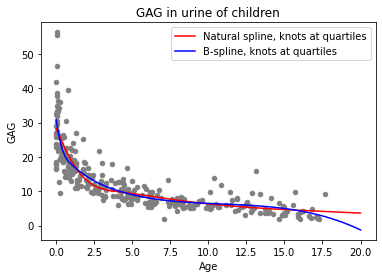

In [50]:
ax32 = GAGurine.plot.scatter(x='Age',y='GAG',c='grey',title="GAG in urine of children")
ax32.set_xlabel("Age")
ax32.set_ylabel("GAG")
ax32.plot(predict_frame.rx2("Age"),ns_out, color='red')
ax32.plot(predict_frame.rx2("Age"),bs_out, color='blue')
ax32.legend(["Natural spline, knots at quartiles","B-spline, knots at quartiles"]);

In [51]:
overfit_formula = robjects.Formula("Gag ~ bs(Age, knots=r_quarts)")
overfit_formula.environment['Gag'] = r_gag
overfit_formula.environment['Age'] = r_age
overfit_formula.environment['r_quarts'] = robjects.FloatVector(np.array([2,4,6,8,10,12,14,16]))

overfit_model = r_lm(overfit_formula)
overfit_out = r_predict(overfit_model, predict_frame)

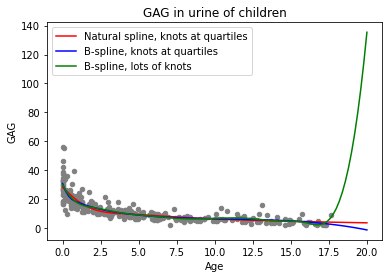

In [52]:
ax32 = GAGurine.plot.scatter(x='Age',y='GAG',c='grey',title="GAG in urine of children")
ax32.set_xlabel("Age")
ax32.set_ylabel("GAG")
ax32.plot(predict_frame.rx2("Age"),ns_out, color='red')
ax32.plot(predict_frame.rx2("Age"),bs_out, color='blue')
ax32.plot(predict_frame.rx2("Age"),overfit_out, color='green')
ax32.legend(["Natural spline, knots at quartiles", "B-spline, knots at quartiles", "B-spline, lots of knots"]);

## GAMs
We come, at last, to our most advanced model. The coding here isn't any more complex than we've done before, though the behind-the-scenes is awesome.

First, let's get our (multivariate!) data

In [53]:
kyphosis = pd.read_csv("data/kyphosis.csv")

print("""
# kyphosis - wherther a particular deformation was present post-operation
# age - patient's age in months
# number - the number of vertebrae involved in the operation
# start - the number of the topmost vertebrae operated on

""")
display(kyphosis.head())
display(kyphosis.describe(include='all'))
display(kyphosis.dtypes)


# kyphosis - wherther a particular deformation was present post-operation
# age - patient's age in months
# number - the number of vertebrae involved in the operation
# start - the number of the topmost vertebrae operated on




,Kyphosis,Age,Number,Start
0,absent,71,3,5
1,absent,158,3,14
2,present,128,4,5
3,absent,2,5,1
4,absent,1,4,15


,Kyphosis,Age,Number,Start
count,81,81.000000,81.000000,81.000000
unique,2,NaN,NaN,NaN
top,absent,NaN,NaN,NaN
freq,64,NaN,NaN,NaN
mean,NaN,83.654321,4.049383,11.493827
std,NaN,58.104251,1.619423,4.883962
min,NaN,1.000000,2.000000,1.000000
25%,NaN,26.000000,3.000000,9.000000
50%,NaN,87.000000,4.000000,13.000000
75%,NaN,130.000000,5.000000,16.000000


Kyphosis    object
Age          int64
Number       int64
Start        int64
dtype: object

In [54]:
#If there are errors about missing R packages, run the code below:

#r_utils = importr('utils')
#r_utils.install_packages('codetools')
#r_utils.install_packages('gam')

To fit a GAM, we
 - Import the `gam` library
 - Populate a formula including `s(<var>)` on variables we want to fit smooths for
 - Call `gam(formula, family=<string>)` where `family` is a string naming a probability distribution, chosen based on how the response variable is thought to occur. 
 - Rough `family` guidelines:
     - Response is binary or "N occurances out of M tries", e.g. number of lab rats (out of 10) developing disease: chooose `"binomial"`
     - Response is a count with no logical upper bound, e.g. number of ice creams sold: choose `"poisson"`
     - Response is real, with normally-distributed noise, e.g. person's height: choose `"gaussian"` (the default)

In [55]:
#There is a Python library in development for using GAMs (https://github.com/dswah/pyGAM)
# but it is not yet as comprehensive as the R GAM library, which we will use here instead.

# R also has the mgcv library, which implements some more advanced/flexible fitting methods

r_gam_lib = importr('gam')
r_gam = r_gam_lib.gam

r_kyph = robjects.FactorVector(kyphosis[["Kyphosis"]].values)
r_Age = robjects.FloatVector(kyphosis[["Age"]].values)
r_Number = robjects.FloatVector(kyphosis[["Number"]].values)
r_Start = robjects.FloatVector(kyphosis[["Start"]].values)

kyph1_fmla = robjects.Formula("Kyphosis ~ s(Age) + s(Number) + s(Start)")
kyph1_fmla.environment['Kyphosis']=r_kyph
kyph1_fmla.environment['Age']=r_Age
kyph1_fmla.environment['Number']=r_Number
kyph1_fmla.environment['Start']=r_Start


kyph1_gam = r_gam(kyph1_fmla, family="binomial")

The fitted gam model has a lot of interesting data within it

In [56]:
print(kyph1_gam.names)

 [1] "smooth.frame"        "coefficients"        "residuals"          

 [4] "fitted.values"       "effects"             "weights"            

 [7] "rank"                "assign"              "qr"                 

[10] "smooth"              "nl.df"               "df.residual"        

[13] "iter"                "var"                 "additive.predictors"

[16] "R"                   "rank"                "family"             

[19] "deviance"            "aic"                 "null.deviance"      

[22] "iter"                "bf.iter"             "prior.weights"      

[25] "y"                   "df.null"             "nl.chisq"           

[28] "model"               "call"                "formula"            

[31] "terms"               "data"                "offset"             

[34] "control"             "method"              "contrasts"          

[37] "xlevels"            



Remember plotting? Calling R's `plot()` on a gam model is the easiest way to view the fitted splines

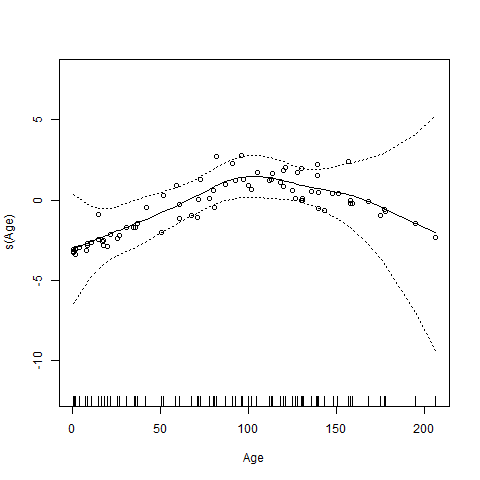

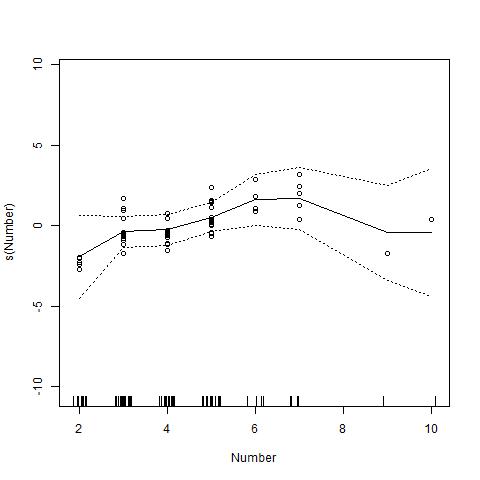

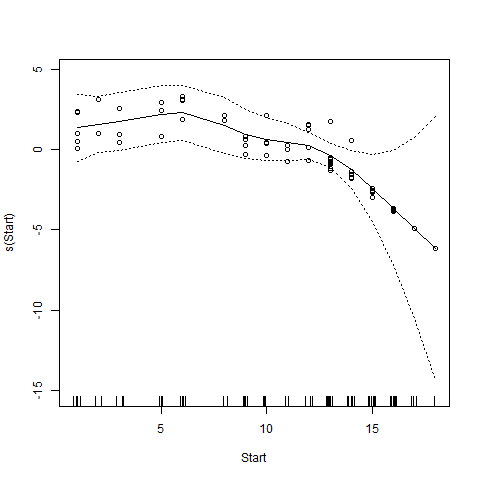

In [57]:
%R -i kyph1_gam plot(kyph1_gam, residuals=TRUE,se=TRUE, scale=20);

Prediction works like normal (build a data frame to predict on, if you don't already have one, and call `predict()`). However, predict always reports the sum of the individual variable effects. If `family` is non-default this can be different from the actual prediction for that point.

For instance, we're doing a 'logistic regression' so the raw prediction is log odds, but we can get probability by using in `predict(..., type="response")`

In [58]:
kyph_new = robjects.DataFrame({'Age': robjects.IntVector((84,85,86)), 
                               'Start': robjects.IntVector((5,3,1)), 
                               'Number': robjects.IntVector((1,6,10))})

print("Raw response (so, Log odds):")
display(r_predict(kyph1_gam, kyph_new))
print("Scaled response (so, probabilty of kyphosis):")
display(r_predict(kyph1_gam, kyph_new, type="response"))

Raw response (so, Log odds):


-2.369793,2.726143,0.363981


Scaled response (so, probabilty of kyphosis):


0.085505,0.938552,0.590004
